# ⚡️ First: 5-Minute Basics

Writing a Trace program involves three simple steps.

1. Write a normal python program.
2. Decorate the program with Trace primitives: `node` and `@bundle`.
3. Use a Trace-graph-compatible optimizer to optimize the program.

In this short tutorial, we will look at a simple example of how Trace allows code optimization on runnable Python code.
Then, we show how you can use Trace to create a **code generation and verifier** framework by alternating between optimizing the code and the unit tests with a dozen lines of code.


In [ ]:
%pip install trace-opt

## Start with a Normal Python Program

To illustrate the fundamental difference between Trace and many other LLM libraries, we can look at a coding problem from OpenAI's Human-Eval dataset. 

In [2]:
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Examples:
    strange_sort_list([1, 2, 3, 4]) == [1, 4, 2, 3]
    strange_sort_list([5, 5, 5, 5]) == [5, 5, 5, 5]
    strange_sort_list([]) == []
    '''
    lst = sorted(lst)
    return lst

In [3]:
strange_sort_list([1, 2, 3, 4])

[1, 2, 3, 4]

Our first attempt is not very successful -- we tried one of the example input and the output is not correct. Can we leverage an LLM to help us automatically figure out the right solution?

## Trace this Program

We use decorators like `@bundle` to wrap over Python functions. A **bundled** function behaves like any other Python functions.

In [4]:
from opto.trace import node, bundle

@bundle(trainable=True)
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Examples:
    strange_sort_list([1, 2, 3, 4]) == [1, 4, 2, 3]
    strange_sort_list([5, 5, 5, 5]) == [5, 5, 5, 5]
    strange_sort_list([]) == []
    '''
    lst = sorted(lst)
    return lst

test_input = [1, 2, 3, 4]
test_output = strange_sort_list(test_input)
print(test_output)

MessageNode: (eval:0, dtype=<class 'list'>, data=[1, 2, 3, 4])


Note that even though `strange_sort_list` is now bundled, it still executes like a normal Python function. The returned value however, is a `MessageNode`. Trace automatically converts input to `Node` and start tracing operations. We can see the output is still the same as we had before.

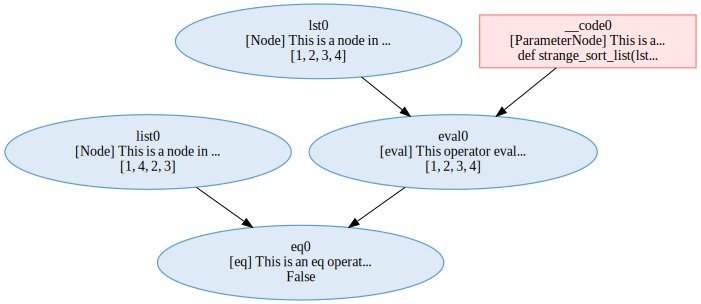

In [5]:
correctness = test_output.eq([1, 4, 2, 3])
correctness.backward("test failed", visualize=True, print_limit=25)

We are not just tracing how the program is run -- we are tracing how we verified the correctness of the output too, all without any manual intervention. Our design philosophy is to support un-interrupted Python programming.

```{note}
You may have noticed that we used `test_output.eq([1, 4, 2, 3])` instead of the more conventional `test_output == [1, 4, 2, 3]`. 
You can try it! Actually, both statements will execute without an error. However, `test_output == [1, 4, 2, 3]` returns a Python boolean object `False`, while `test_output.eq([1, 4, 2, 3])` returns a Trace `MessageNode`. We have taken great effor to make Node objects work just like any Python objects, but there are some corner cases to watch out for.
```

## Optimize with Feedback

We can use Trace and the optimizer defined in `opto.optimizers` to learn a program that can pass this test! But first, we need to provide some signal to the optimizer. We call this signal **feedback**. The more intelligent the optimizer is, the less guidance we need to give in the feedback. Think of this as us providing instructions to help LLM-based optimizers to come up with better solutions.

```{note}
You might be thinking -- `correctness` is already a boolean variable and has a name `correctness`. Why do we need to explicitly provide a feedback string to the optimizer? This is because just by `False` or `True` -- it is hard to know whether the test has passed or not. We could be testing on a positive or a negative target. Therefore, it is important to pass in an explicit feedback.
```

```{tip}
What do we have to write without Trace? If you are using a ChatGPT/Bard/Claude interface, you will copy paste the code into the interface, ask it to write code for you. Copy/paste the code back into a code editor that has Python runtime. Execute the Python code. Compare the output with the ground truth, and then write in the chat interface `test case failed!`. Trace simplified all of these steps.
```

In [6]:
def get_feedback(predict, target):
    if predict == target:
        return "test case passed!"
    else:
        return "test case failed!"

In order for the optimization code to run, create a file with name `OAI_CONFIG_LIST` in the same folder as this notebook. This file should look the same as [OAI_CONFIG_LIST](https://github.com/microsoft/autogen/blob/main/OAI_CONFIG_LIST_sample).

The code below looks like any PyTorch code. We can break it down to a few steps:
1. We first import an optimizer from `opto.optimizers`.
2. The bundled function `strange_sort_list` has a convenience method `.parameters()` for us to grab all the trainable parameters in it. In this case, the trainable parameter is just the function code itself.
3. We need to perform `backward` pass on a `MessageNode` object, which is `correctness`. We also need to pass in the `feedback` into the optimizer as well.
4. We call `optimizer.step()` to perform the actual optimization

In [7]:
import autogen
from opto.optimizers import OptoPrime
from opto import trace

test_ground_truth = [1, 4, 2, 3]
test_input = [1, 2, 3, 4]

epoch = 2

optimizer = OptoPrime(strange_sort_list.parameters(),
                      config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

for i in range(epoch):
    print(f"Training Epoch {i}")
    try:
        test_output = strange_sort_list(test_input)
        feedback = get_feedback(test_output, test_ground_truth)
    except trace.ExecutionError as e:
        feedback = e.exception_node.data
        test_output = e.exception_node
    
    correctness = test_output.eq(test_ground_truth)
    
    if correctness:
        break

    optimizer.zero_feedback()
    optimizer.backward(correctness, feedback)
    optimizer.step()

Training Epoch 0
Training Epoch 1


We can visualize what the optimizer is doing. Trace first constructs a tuple `(g0, f0)`, which corresponds to `(Trace graph, feedback)`. Trace graph is a representation of what happened in the execution. Feedback is provided by the `get_feedback` function we defined above. 

The LLM-based optimizer is then asked to generate a rationale/reasoning `r1`, and then an improvement `a1` is proposed.

```{note}
Trace graph contains a `#Code` section. However, this does not look like the `strange_sort_list` function we wrote. The actual function is in the `#Variables` section. This is because we chose to use a specific optimizer `OptoPrime`, which frames the optimization problem as a code "debugging" problem, and uses the `#Code` section to represent the computation flow.
```

In [8]:
from opto.trace.utils import render_opt_step

render_opt_step(0, optimizer)

```{note}
We can examine what the learned function look like by printing out its content below. Calling `.data` on a node returns the wrapped data inside the node.
```

In [9]:
print(strange_sort_list.parameters()[0].data)

def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Examples:
    strange_sort_list([1, 2, 3, 4]) == [1, 4, 2, 3]
    strange_sort_list([5, 5, 5, 5]) == [5, 5, 5, 5]
    strange_sort_list([]) == []
    '''
    result = []
    ascending = True
    while lst:
        if ascending:
            value = min(lst)
            lst.remove(value)
        else:
            value = max(lst)
            lst.remove(value)
        result.append(value)
        ascending = not ascending
    return result


## The Optimized Function is Runnable

You might wonder -- oh, is this function actually changed? Yes it is. In fact, we can pass in a different test example and see if it worked.

In [10]:
new_test_input = [5, 3, 2, 5]
new_test_output = strange_sort_list(new_test_input)
print(new_test_output)

MessageNode: (eval:3, dtype=<class 'list'>, data=[2, 5, 3, 5])


**Now the answer is correct!** (alternating numbers between min, max, min, max!)

## Save and Load the Optimized Function

In fact, just like PyTorch, you can easily save and load this function too. We will discuss more details in the next section.

In [11]:
strange_sort_list.save("strange_sort_list.pkl")

## Coder-Verifier Framework using Trace

The functionalities provided by Trace seem simple and straightforward right now. But using these as basic building blocks, we can construct LLM-based workflow that is complex and mind-blowing. 

Earlier, we used a unit test provided by the dataset. What if we don't have any unit test, or if we wonder the tests are exhaustive or not? Trace takes an optimization perspective that can allow you to write multiple functions -- we can write a function that proposes unit tests for another function. Let's call this function a `verifier`.

```{tip}
Trace does not force users to wrap Python functions into a string in order to send to an optimizer. This allows natural Python programming flow. Trace manages the function body under the hood.
```

```{note}
Note that we removed the examples in the function docstring below!
```

MessageNode: (eval:1, dtype=<class 'list'>, data=[1, 2, 3])


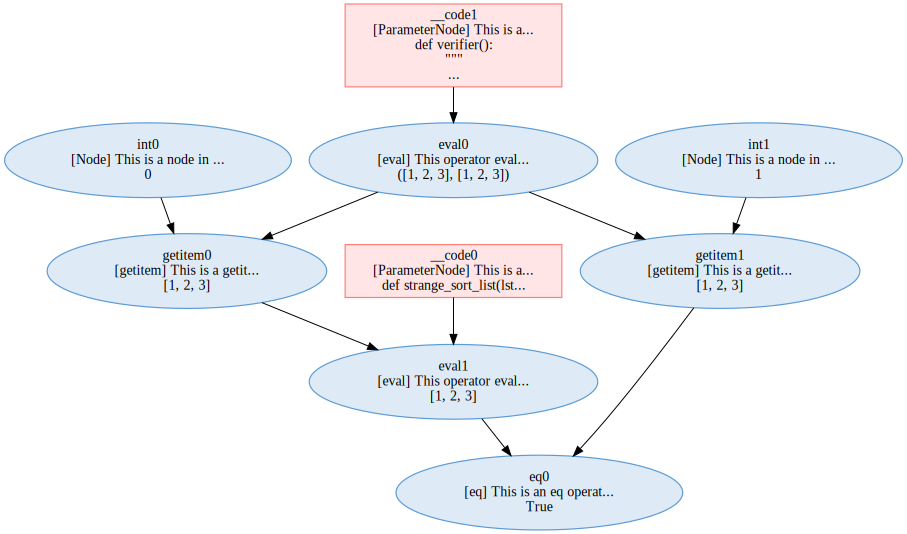

In [12]:
from opto.trace import node, bundle, GRAPH
GRAPH.clear()

@bundle(trainable=True)
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.
    '''
    return sorted(lst)

@bundle(trainable=True)
def verifier():
    """
    For a coding problem described below:
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Return a test input and an expected output to verify if the function is implemented correctly.
    """
    test_input = [1,2,3]
    expected_output = [1,2,3]
    return test_input, expected_output

test_input, expected_output =  verifier()
test_output = strange_sort_list(test_input)
print(test_output)
verifier_passed = test_output.eq(expected_output)
verifier_passed.backward("synthetic test result", visualize=True, print_limit=25)

Wow. It looks like we passed the synthetic test! Encouraging! Except, the proposed unit test is wrong. This is when the optimization perspective becomes important. Both the unit test function and the code writing function need to be optimized. 



Let's come up with a game that can help the code function to write better code.

Given a pair of ground truth input and expected output, we define the following procedure:

1. Create two functions: `coder` and `verifier`.
2. `coder` will keep **optimizing** its code unless the `verifier` agrees to let it pass.
3. Now the `coder` will take the ground truth input and be checked against ground truth output.
4. If the `coder` fails, `verifier` will **optimize** its internal tests.

```{tip}
In the Trace framework, feedback is similar to how we understand `loss` or `metric` in classical machine learning. We need to use it to guide the optimizer to change the the function's behavior.
```

In [13]:
import autogen
from opto.optimizers import OptoPrime

GRAPH.clear()

test_ground_truth = [1, 4, 2, 3]
test_ground_truth_input = [1, 2, 3, 4]

epoch = 2

code_optimizer = OptoPrime(strange_sort_list.parameters(),
                          config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"),
                          ignore_extraction_error=True)
verifier_optimizer = OptoPrime(verifier.parameters(),
                              config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"),
                              ignore_extraction_error=True)

for i in range(epoch):
    print(f"Training Epoch {i}")

    # Step 2: Coder optimizes till it passes the verifier
    verifier_passed = False
    while not verifier_passed:
        print(f"Code function update")
        try:
            test_input, expected_output =  verifier()
            test_output = strange_sort_list(test_input)
            # note that we use the same feedback function as before
            feedback = get_feedback(test_output.data, expected_output.data)
        except trace.ExecutionError as e:
            feedback = e.exception_node.data
            test_output = e.exception_node
            expected_output = None
        verifier_passed = test_output.eq(expected_output)
        
        code_optimizer.zero_feedback()
        code_optimizer.backward(verifier_passed, feedback, retain_graph=True)
        code_optimizer.step()

    # Step 3: Coder is checked by ground truth
    try:
        test_output = strange_sort_list(test_ground_truth_input)
        feedback = get_feedback(test_output, test_ground_truth)
    except trace.ExecutionError as e:
        feedback = e.exception_node.data
        test_output = e.exception_node
    correctness = test_output.eq(test_ground_truth)
    
    if correctness:
        break

    # Step 4: If the Coder fails, Verifier needs to propose better unit tests
    print(f"Verifier update")
    feedback = "Verifier proposed wrong test_input, expected_output that do not validate the implementation of the function."
    verifier_optimizer.zero_feedback()
    verifier_optimizer.backward(verifier_passed, feedback)
    verifier_optimizer.step()

Training Epoch 0
Code function update
Verifier update
Training Epoch 1
Code function update
Code function update
Code function update
Code function update


In [14]:
print(strange_sort_list.parameters()[0])

ParameterNode: (__code:0, dtype=<class 'str'>, data=def strange_sort_list(lst):
    result = []
    min_index = 0
    max_index = len(lst) - 1
    sorted_lst = sorted(lst)
    while min_index <= max_index:
        result.append(sorted_lst[min_index])
        min_index += 1
        if min_index <= max_index:
            result.append(sorted_lst[max_index])
            max_index -= 1
    return result)


In [15]:
print(verifier.parameters()[0])

ParameterNode: (__code:1, dtype=<class 'str'>, data=def verifier():
    """
    For a coding problem described below:
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Return a test input and an expected output to verify if the function is implemented correctly.
    """
    test_input = [3, 1, 2]
    expected_output = [1, 3, 2]
    return test_input, expected_output)


```{note}
`[3, 1, 2]` came up by the verifier is not in the function docstring examples.
```

## What's Next?

We can see that the verifier can come up with good examples to test if the code function is correct, and the code function itself does not need ground-truth answers to update. All of these can be achieved within the optimization framework of Trace.

This is not the end of what Trace can do. Next, we will demonstrate how we can write a Python **class** object that can be optimized by Trace using what we learned here. 